In [3]:
import torch, random, numpy as np

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_top_k(logits, top_k=5):
    """
    logits: (B, T, vocab_size)
    Returns a list of top-k token IDs for the last position, e.g. [id1, id2,...].
    """
    last_logits = logits[:, -1, :]       # shape (B, vocab_size)
    probs = torch.softmax(last_logits, dim=-1)
    top_vals, top_indices = probs.topk(top_k, dim=-1)
    # top_indices is shape (B, top_k). For B=1, we do top_indices[0].tolist().
    return top_indices[0].tolist()

def detect_ngram_copy(seq_ids: torch.Tensor, n=3, skip_up_to=43):
    """
    Minimal function that tries to find n-gram copy scenario
    """
    T = seq_ids.size(1)  # shape (B=1, T)
    if T < n:
        return None, None
    # 1) last token
    last_token = seq_ids[0, -1].item()
    # 2) find earlier positions of last_token
    possible_pos = (seq_ids[0, :-1] == last_token).nonzero().view(-1)
    if possible_pos.numel() == 0:
        return None, None
    # 3) check (n-1) context
    n_minus_1 = n - 1
    context_needed = seq_ids[0, -(n_minus_1+1):-1]  # last n-1 tokens
    matched_pos = None
    for pos in reversed(possible_pos):
        if pos >= n_minus_1:
            candidate = seq_ids[0, pos-n_minus_1:pos]
            if torch.all(candidate == context_needed):
                matched_pos = pos.item()
                break
    if matched_pos is None:
        return None, None
    else:
        return matched_pos, skip_up_to

In [4]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return  intersection / union


def get_acc(info_lst):
    jcc_ult = []
    acc_ult = []

    for data in info_lst:
        acc_lst = []
        jc_lst = []
        for step in data.keys():
            copy = data[step]['copy']
            original = data[step]['original']

            jaccard_score = jaccard_similarity(copy, original)
            jc_lst.append(jaccard_score)

            acc_score = 1 if copy[0] == original[0] else 0
            acc_lst.append(acc_score)

        jcc_ult.append(jc_lst)
        acc_ult.append(acc_lst)
    
    def cal_avg(lsts):
        avg_lst = []
        for lst in lsts:
            if len(lst) == 0:
                continue
            avg_lst.append(sum(lst) / len(lst))
        return sum(avg_lst) / len(avg_lst)

    avg_jcc = cal_avg(jcc_ult)
    avg_acc = cal_avg(acc_ult)

    return avg_jcc, avg_acc

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_skip_layer_metrics(skip_layers, accuracy3, jaccard_similarity, model_name, schema):
    """
    Plots a grouped bar chart of Accuracy 3 and Jaccard Similarity for different skip layers.
    
    Parameters:
      skip_layers (list): List of skip layer values (e.g., [5, 10, 15, 20, 25, 30]).
      accuracy3 (list): List of Accuracy 3 values corresponding to each skip layer.
      jaccard_similarity (list): List of Jaccard similarity values corresponding to each skip layer.
    """
    # Create an array with the positions for each skip layer on the x-axis.
    x = np.arange(len(skip_layers))
    width = 0.35  # width of each bar

    # Create the plot and two sets of bars.
    fig, ax = plt.subplots(figsize=(8, 5))
    bars_acc = ax.bar(x - width/2, accuracy3, width, label='Accuracy')
    bars_jacc = ax.bar(x + width/2, jaccard_similarity, width, label='Jaccard Similarity')

    # Label the axes and add a title
    ax.set_xlabel('Skip Layers')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'{schema}: {model_name}\'s Accuracy and Jaccard Similarity by Skip Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(skip_layers)
    ax.legend(loc = 'lower right')

    # Add numerical labels above the bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(bars_acc)
    autolabel(bars_jacc)

    plt.tight_layout()
    plt.show()

In [6]:
import re
def extract_metrics(text):
    # Find all occurrences of "Avg accuracy 3: " followed by a floating-point number
    acc_matches = re.findall(r"Avg accuracy 3:\s+([0-9\.]+)", text)
    jcc_matches = re.findall(r"Avg jaccard similarity:\s+([0-9\.]+)", text)
    # Convert matches to float
    return [float(value) for value in acc_matches], [float(value) for value in jcc_matches]

In [7]:
# Import stuff
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm

from jaxtyping import Float
from functools import partial

# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

import torch
torch.set_grad_enabled(False)

In [8]:
from transformer_lens import HookedTransformer
import torch
from transformers import GPT2Tokenizer, Qwen2Tokenizer


# load model and tokenizer
model = HookedTransformer.from_pretrained("Qwen/Qwen2.5-3B")
# tokenizer = Qwen2Tokenizer.from_pretrained("Qwen/Qwen2.5-3B")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen2.5-3B into HookedTransformer


In [20]:
from datasets import load_from_disk
from tqdm import tqdm

# Load the dataset from disk
num_samples = 5000
subset = load_from_disk("/home/longnhat/workspace_phu/CopyMech/english_insertions")
prompt_list = []

base_sents = subset['train']['base_sentence'][:num_samples]
phrases = subset['train']['phrase'][:num_samples]
edited_sents = subset['train']['edited_sentence'][:num_samples]

import gc
del subset
gc.collect()

2190

# Plots on the Turning Points

In [7]:
import time
import torch
from tqdm import tqdm
from collections import defaultdict

def mini_acc(dict_pred_info):
    acc_lst = []
    for step in dict_pred_info.keys():
        copy = dict_pred_info[step]['copy']
        original = dict_pred_info[step]['original']

        acc_score = 1 if copy[0] == original[0] else 0
        acc_lst.append(acc_score)
    return sum(acc_lst) / len(acc_lst)

def has_required_spaces(seq: str) -> bool:
    """
    Returns True if the sequence has an occurrence of 'is' or 'are'
    that is preceded (anywhere earlier in the sequence) by at least 6 tokens that are exactly 'space'.
    
    Examples:
      'There space space space space space oh space is a cat.' -> True
      'There space are many cats.' -> False
      'There is a cat.' -> False
      'There space space space space space space is a cat.' -> True
      'There spaces are many cats.' -> False
    """
    tokens = seq.split()
    # check if sentence only has 1 is or are
    if tokens.count("is") + tokens.count("are") != 1:
        return False
    for i, token in enumerate(tokens):
        if token in {"is", "are"}:
            # Count how many tokens before this occurrence are exactly "space"
            if len(tokens[:i]) >= 6:
                return True
    return False

def text_preprocess(text):
    """Given a text, replace ' is ' by ' are ', and vice versa. Return the corrupted text, and the text until the first is/are."""
    text = text.strip()
    if ' is ' in text:
        corrupted_text = text.replace(' is ', ' are ', 1)
    elif ' are ' in text:
        corrupted_text = text.replace(' are ', ' is ', 1)
    
    # find position of first is/are and return text before that
    first_is = text.find(' is ')
    first_are = text.find(' are ')
    if first_is == -1 and first_are == -1:
        return None
    elif first_is == -1:
        return corrupted_text, text[:first_are], 'are'
    elif first_are == -1:
        return corrupted_text, text[:first_is], 'is'
    
    return corrupted_text, text[:min(first_is, first_are)]

def ngram(n, model, skip_up_to, max_steps, extra_steps, k, edited_phrases):

    print("n-gram: ", n)
    print("Skip layers: ", skip_up_to)

    info_lst = []
    failed_lst = []

    total_failed_by_prepocess = 0
    total_failed_as_ulsolvable = 0
    total_solvable_og = 0
    total_solvable_pt = 0
    total_matches = []

    num_matched = 0
    total_steps = 0

    for edited in tqdm(edited_phrases):

        if total_solvable_og == 100:
            break

        if not has_required_spaces(edited):
            continue

        # preprocess text
        edited = text_preprocess(edited)
        if edited is None:
            total_failed_by_prepocess += 1
            continue
        corrupted_text, pre_isare, correct_tobe = edited
        prompt = f"Please fix grammar of the following text: '{corrupted_text}'. The correct text is: {pre_isare}"

        # edited_ids = tokenizer.encode(edited, return_tensors='pt')
        # steps = extra_steps + edited_ids.size(1)
        # if steps > max_steps:
        #     steps = max_steps
        # total_steps += steps
        steps = 1

        dict_pred_info = defaultdict(dict)

        for step_i in range(steps):
            prompt_tokens = model.to_tokens(prompt)

            if step_i != 0:
                prompt_tokens = model.to_tokens(prompt, prepend_bos=False)

            # run on the prompt once with cache to store activations to patch in later
            og_logits, og_cache = model.run_with_cache(prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(og_logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

            # check if model can solve the task
            decoded_og_next_token = model.to_string(og_next_token)[0]
            if 'are' in decoded_og_next_token and correct_tobe == 'are':
                total_solvable_og += 1
            elif 'is' in decoded_og_next_token and correct_tobe == 'is':
                total_solvable_og += 1
            else:
                continue

            # detect copy scenario
            t_matched, _ = detect_ngram_copy(prompt_tokens, n=n, skip_up_to=skip_up_to)
            if t_matched is not None:
                num_matched += 1

                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    position: int
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, -1, :] = clean_resid_pre[:, position, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, position=t_matched)
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])

                # def v_patching_hook(
                #     resid_pre: Float[torch.Tensor, "batch pos head_index d_head"],
                #     hook: HookPoint,
                #     position: int
                # ) -> Float[torch.Tensor, "batch pos head_index d_head"]:
                #     # Each HookPoint has a name attribute giving the name of the hook.
                #     clean_resid_pre = og_cache[hook.name]
                #     resid_pre[:, -1, :, :] = clean_resid_pre[:, position, :, :]
                #     return resid_pre
                
                # for layer in range(skip_up_to):
                #     # Use functools.partial to create a temporary hook function with the position fixed
                #     temp_hook_fn = partial(v_patching_hook, position=t_matched)
                #     # Run the model with the patching hook
                #     patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                #         (utils.get_act_name("v", layer), temp_hook_fn)
                #     ])
                
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # check if model can solve the task
                decoded_pt_next_token = model.to_string(pt_next_token)[0]
                if 'are' in decoded_pt_next_token and correct_tobe == 'are':
                    total_solvable_pt += 1
                elif 'is' in decoded_pt_next_token and correct_tobe == 'is':
                    total_solvable_pt += 1

                if torch.equal(og_next_token, pt_next_token):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                # # append the token to the sequence
                # pt_prompt_tokens = torch.cat([prompt_tokens, pt_next_token], dim=1)
                # # deocde the token
                # pt_prompt = model.to_string(pt_prompt_tokens)[0]      
                # print('PT:\n')
                # print(pt_prompt)

                dict_pred_info[step_i]['original'] = og_topk_indices
                dict_pred_info[step_i]['copy'] = get_top_k(patched_logits, k)

            # # append the token to the sequence
            # prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)
            # # deocde the token
            # prompt = model.to_string(prompt_tokens)[0]
            # print('OG:\n')
            # print(prompt)
            # print("Avg accuracy: ", total_solvable_pt / total_solvable_og)
            # a

        info_lst.append(dict_pred_info)

    print("Avg accuracy 1: ", total_solvable_pt / total_solvable_og)
        
    jcc, acc = get_acc(info_lst)
    print("Avg jaccard similarity: ", jcc)
    print("Avg accuracy 2: ", acc)
    print("Avg accuracy 3: ", sum(total_matches) / len(total_matches))
    print(total_solvable_og, total_solvable_pt)

In [8]:
seed = 5
extra_steps = 5
max_steps = 1024
k=100
seed_everything(seed)

ns = [5]
skip_up_to = [5, 10, 15, 20, 25, 30]
info_lst = {}
for n in ns:
    info_lst[n] = {}
    for skip in skip_up_to:
        info_lst[n][skip] = {}
        outputs = ngram(n, model, skip, max_steps, extra_steps, k, edited_sents)
        # info_lst[n][skip]['info'] = outputs[0]
        # info_lst[n][skip]['failed'] = outputs[1]
        # info_lst[n][skip]['num_matched'] = outputs[2]
        # info_lst[n][skip]['jcc'] = outputs[3]
        # info_lst[n][skip]['acc'] = outputs[4]
        print("-----------------------------------")

n-gram:  5
Skip layers:  5


 70%|██████▉   | 1046/1500 [00:15<00:06, 66.54it/s]


Avg accuracy 1:  1.0
Avg jaccard similarity:  0.9358150034359433
Avg accuracy 2:  1.0
Avg accuracy 3:  1.0
100 100
-----------------------------------
n-gram:  5
Skip layers:  10


 70%|██████▉   | 1046/1500 [00:15<00:06, 66.38it/s]


Avg accuracy 1:  0.95
Avg jaccard similarity:  0.7987403478577427
Avg accuracy 2:  0.95
Avg accuracy 3:  0.95
100 95
-----------------------------------
n-gram:  5
Skip layers:  15


 70%|██████▉   | 1046/1500 [00:15<00:06, 65.87it/s]


Avg accuracy 1:  0.9
Avg jaccard similarity:  0.7642517641267719
Avg accuracy 2:  0.9
Avg accuracy 3:  0.9
100 90
-----------------------------------
n-gram:  5
Skip layers:  20


 70%|██████▉   | 1046/1500 [00:15<00:06, 65.59it/s]


Avg accuracy 1:  0.73
Avg jaccard similarity:  0.6636194307681513
Avg accuracy 2:  0.73
Avg accuracy 3:  0.73
100 73
-----------------------------------
n-gram:  5
Skip layers:  25


 70%|██████▉   | 1046/1500 [00:15<00:06, 65.42it/s]


Avg accuracy 1:  0.88
Avg jaccard similarity:  0.4883484373740615
Avg accuracy 2:  0.87
Avg accuracy 3:  0.87
100 88
-----------------------------------
n-gram:  5
Skip layers:  30


 70%|██████▉   | 1046/1500 [00:16<00:06, 65.15it/s]

Avg accuracy 1:  0.78
Avg jaccard similarity:  0.36759101435328767
Avg accuracy 2:  0.77
Avg accuracy 3:  0.77
100 78
-----------------------------------


In [7]:
text = '''
n-gram:  5
Skip layers:  5
 70%|██████▉   | 1046/1500 [00:15<00:06, 66.54it/s]
Avg accuracy 1:  1.0
Avg jaccard similarity:  0.9358150034359433
Avg accuracy 2:  1.0
Avg accuracy 3:  1.0
100 100
-----------------------------------
n-gram:  5
Skip layers:  10
 70%|██████▉   | 1046/1500 [00:15<00:06, 66.38it/s]
Avg accuracy 1:  0.95
Avg jaccard similarity:  0.7987403478577427
Avg accuracy 2:  0.95
Avg accuracy 3:  0.95
100 95
-----------------------------------
n-gram:  5
Skip layers:  15
 70%|██████▉   | 1046/1500 [00:15<00:06, 65.87it/s]
Avg accuracy 1:  0.9
Avg jaccard similarity:  0.7642517641267719
Avg accuracy 2:  0.9
Avg accuracy 3:  0.9
100 90
-----------------------------------
n-gram:  5
Skip layers:  20
 70%|██████▉   | 1046/1500 [00:15<00:06, 65.59it/s]
Avg accuracy 1:  0.73
Avg jaccard similarity:  0.6636194307681513
Avg accuracy 2:  0.73
Avg accuracy 3:  0.73
100 73
-----------------------------------
n-gram:  5
Skip layers:  25
 70%|██████▉   | 1046/1500 [00:15<00:06, 65.42it/s]
Avg accuracy 1:  0.88
Avg jaccard similarity:  0.4883484373740615
Avg accuracy 2:  0.87
Avg accuracy 3:  0.87
100 88
-----------------------------------
n-gram:  5
Skip layers:  30
 70%|██████▉   | 1046/1500 [00:16<00:06, 65.15it/s]
Avg accuracy 1:  0.78
Avg jaccard similarity:  0.36759101435328767
Avg accuracy 2:  0.77
Avg accuracy 3:  0.77
100 78
-----------------------------------
'''
accuracy3,jaccard_similarity = extract_accuracy_3(text)

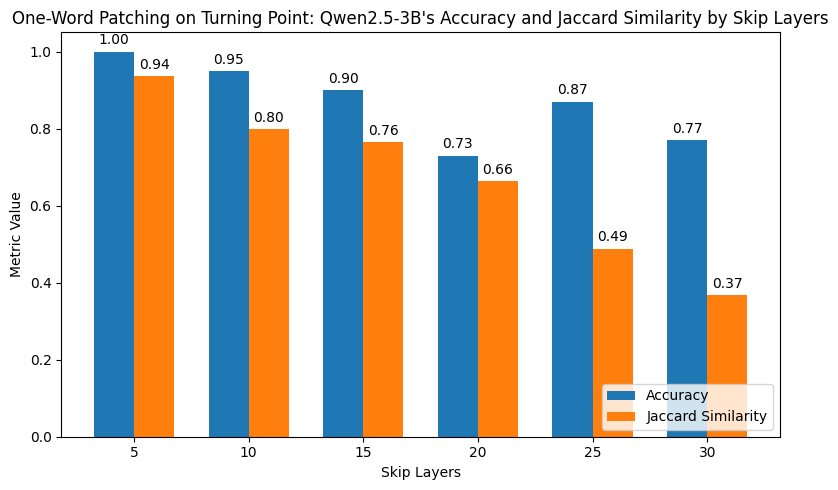

In [9]:
# Example data based on the results:
skip_layers = [5, 10, 15, 20, 25, 30]
plot_skip_layer_metrics(skip_layers, accuracy3, jaccard_similarity, model_name="Qwen2.5-3B", schema="One-Word Patching on Turning Point")

# Plots Not the Turning Points
A B "C" D is .... A B "C" D are
- Turning points is the final word are
- Not the turning point is the word D.

In this section, we plots if we patch the word C is the model still able to predict the word D? (still in the copy mode)

In [18]:
import time
import torch
from tqdm import tqdm
from collections import defaultdict

def mini_acc(dict_pred_info):
    acc_lst = []
    for step in dict_pred_info.keys():
        copy = dict_pred_info[step]['copy']
        original = dict_pred_info[step]['original']

        acc_score = 1 if copy[0] == original[0] else 0
        acc_lst.append(acc_score)
    return sum(acc_lst) / len(acc_lst)

def has_required_spaces(seq: str, num_context = 7) -> bool:
    """
    Returns True if the sequence has an occurrence of 'is' or 'are'
    that is preceded (anywhere earlier in the sequence) by at least 6 tokens that are exactly 'space'.
    
    Examples:
      'There space space space space space oh space is a cat.' -> True
      'There space are many cats.' -> False
      'There is a cat.' -> False
      'There space space space space space space is a cat.' -> True
      'There spaces are many cats.' -> False
    """
    tokens = seq.split()
    # check if sentence only has 1 is or are
    if tokens.count("is") + tokens.count("are") != 1:
        return False
    for i, token in enumerate(tokens):
        if token in {"is", "are"}:
            # Count how many tokens before this occurrence are exactly "space"
            if len(tokens[:i]) >= num_context:
                return True
    return False

def text_preprocess(text):
    """Given a text, replace ' is ' by ' are ', and vice versa. Return the corrupted text, and the text until the first is/are."""
    text = text.strip()
    if ' is ' in text:
        corrupted_text = text.replace(' is ', ' are ', 1)
    elif ' are ' in text:
        corrupted_text = text.replace(' are ', ' is ', 1)
    
    # find position of first is/are and return text before that
    first_is = text.find(' is ')
    first_are = text.find(' are ')
    if first_is == -1 and first_are == -1:
        return None
    elif first_is == -1:
        return corrupted_text, text[:first_are], 'are'
    elif first_are == -1:
        return corrupted_text, text[:first_is], 'is'
    
    return corrupted_text, text[:min(first_is, first_are)]

def ngram(n, model, skip_up_to, max_steps, extra_steps, k, edited_phrases):

    print("n-gram: ", n)
    print("Skip layers: ", skip_up_to)

    info_lst = []
    failed_lst = []

    total_failed_by_prepocess = 0
    total_failed_as_ulsolvable = 0
    total_solvable_og = 0
    total_solvable_pt = 0
    total_matches = []

    num_matched = 0
    total_steps = 0

    for edited in tqdm(edited_phrases):

        if total_solvable_og == 100:
            break

        if not has_required_spaces(edited):
            continue

        # preprocess text
        edited = text_preprocess(edited)
        if edited is None:
            total_failed_by_prepocess += 1
            continue

        corrupted_text, pre_isare, correct_tobe = edited
        prompt = f"Please fix grammar of the following text: '{corrupted_text}'. The correct text is: {pre_isare}"

        dict_pred_info = defaultdict(dict)

        steps = 1
        for step_i in range(steps):
            # print(prompt)

            if step_i != 0:
                # Prompt: A B C D is .... A B C D [are]
                prompt_tokens = model.to_tokens(prompt, prepend_bos=False)
            else:
                prompt_tokens = model.to_tokens(prompt)

            # print('og prompt: ', prompt_tokens)

            # As we does not need on the turning point, we can skip the last tokens
            # Prompt: A B C D is .... A B C [D]
            # Get the last token of the prompt as the token to predict
            next_token_ref = prompt_tokens[:, -1]
            prompt_tokens = prompt_tokens[:, :-1]      

            # run on the prompt once with cache to store activations to patch in later
            og_logits, og_cache = model.run_with_cache(prompt_tokens)
            # get the top k tokens
            og_topk_indices = get_top_k(og_logits, k)
            # get the highest prob token
            og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

            # # append the token to the sequence
            # prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)
            # print('generated: ', prompt_tokens)
            # # deocde the token
            # prompt = model.to_string(prompt_tokens)[0]
            # print('OG:', prompt)            

            # check if model can solve the task (now, D should be predicted, aka next_token_ref)
            if torch.equal(og_next_token[0], next_token_ref):
                total_solvable_og += 1
            else:
                continue

            # detect copy scenario
            # Prompt: A B C D is .... A B C [D]
            t_matched, _ = detect_ngram_copy(prompt_tokens, n=n, skip_up_to=skip_up_to)
            if t_matched is not None:
                num_matched += 1

                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    position: int
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, -1, :] = clean_resid_pre[:, position, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, position=t_matched)
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])

                # def v_patching_hook(
                #     resid_pre: Float[torch.Tensor, "batch pos head_index d_head"],
                #     hook: HookPoint,
                #     position: int
                # ) -> Float[torch.Tensor, "batch pos head_index d_head"]:
                #     # Each HookPoint has a name attribute giving the name of the hook.
                #     clean_resid_pre = og_cache[hook.name]
                #     resid_pre[:, -1, :, :] = clean_resid_pre[:, position, :, :]
                #     return resid_pre
                
                # for layer in range(skip_up_to):
                #     # Use functools.partial to create a temporary hook function with the position fixed
                #     temp_hook_fn = partial(v_patching_hook, position=t_matched)
                #     # Run the model with the patching hook
                #     patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                #         (utils.get_act_name("v", layer), temp_hook_fn)
                #     ])
                
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # check if model can solve the task
                if torch.equal(next_token_ref, pt_next_token[0]):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                # # append the token to the sequence
                # pt_prompt_tokens = torch.cat([prompt_tokens, pt_next_token], dim=1)
                # # deocde the token
                # pt_prompt = model.to_string(pt_prompt_tokens)[0]      
                # print('PT:\n')
                # print(pt_prompt)

                dict_pred_info[step_i]['original'] = og_topk_indices
                dict_pred_info[step_i]['copy'] = get_top_k(patched_logits, k)

            # # append the token to the sequence
            # prompt_tokens = torch.cat([prompt_tokens, og_next_token], dim=1)
            # # deocde the token
            # prompt = model.to_string(prompt_tokens)[0]
            # print('OG:\n')
            # print(prompt)
            # print("Avg accuracy: ", total_solvable_pt / total_solvable_og)
            # a

        info_lst.append(dict_pred_info)
        
    jcc, acc = get_acc(info_lst)
    print("Avg jaccard similarity: ", jcc)
    print("Avg accuracy 2: ", acc)
    print("Avg accuracy 3: ", sum(total_matches) / len(total_matches))
    # print(total_solvable_og, total_solvable_pt)

In [19]:
seed = 5
extra_steps = 5
max_steps = 1024
k=100
seed_everything(seed)

ns = [5]
skip_up_to = [5, 10, 15, 20, 25, 30]
info_lst = {}
for n in ns:
    info_lst[n] = {}
    for skip in skip_up_to:
        info_lst[n][skip] = {}
        outputs = ngram(n, model, skip, max_steps, extra_steps, k, edited_sents)
        print("-----------------------------------")

n-gram:  5
Skip layers:  5


 45%|████▍     | 673/1500 [00:11<00:14, 57.55it/s] 


Avg jaccard similarity:  0.9229391438881348
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
-----------------------------------
n-gram:  5
Skip layers:  10


 45%|████▍     | 673/1500 [00:11<00:14, 57.58it/s]


Avg jaccard similarity:  0.7736842093518572
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
-----------------------------------
n-gram:  5
Skip layers:  15


 45%|████▍     | 673/1500 [00:11<00:14, 57.44it/s] 


Avg jaccard similarity:  0.7189210675741292
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
-----------------------------------
n-gram:  5
Skip layers:  20


 45%|████▍     | 673/1500 [00:11<00:14, 57.04it/s] 


Avg jaccard similarity:  0.5911475312514838
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
-----------------------------------
n-gram:  5
Skip layers:  25


 45%|████▍     | 673/1500 [00:11<00:14, 56.69it/s] 


Avg jaccard similarity:  0.44044339309007563
Avg accuracy 2:  0.92
Avg accuracy 3:  0.92
-----------------------------------
n-gram:  5
Skip layers:  30


 45%|████▍     | 673/1500 [00:11<00:14, 56.61it/s] 

Avg jaccard similarity:  0.342329385239778
Avg accuracy 2:  0.65
Avg accuracy 3:  0.65
-----------------------------------


In [20]:
text = '''
n-gram:  5
Skip layers:  5
 45%|████▍     | 673/1500 [00:11<00:14, 57.55it/s] 
Avg jaccard similarity:  0.9229391438881348
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
-----------------------------------
n-gram:  5
Skip layers:  10
 45%|████▍     | 673/1500 [00:11<00:14, 57.58it/s]
Avg jaccard similarity:  0.7736842093518572
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
-----------------------------------
n-gram:  5
Skip layers:  15
 45%|████▍     | 673/1500 [00:11<00:14, 57.44it/s] 
Avg jaccard similarity:  0.7189210675741292
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
-----------------------------------
n-gram:  5
Skip layers:  20
 45%|████▍     | 673/1500 [00:11<00:14, 57.04it/s] 
Avg jaccard similarity:  0.5911475312514838
Avg accuracy 2:  0.99
Avg accuracy 3:  0.99
-----------------------------------
n-gram:  5
Skip layers:  25
 45%|████▍     | 673/1500 [00:11<00:14, 56.69it/s] 
Avg jaccard similarity:  0.44044339309007563
Avg accuracy 2:  0.92
Avg accuracy 3:  0.92
-----------------------------------
n-gram:  5
Skip layers:  30
 45%|████▍     | 673/1500 [00:11<00:14, 56.61it/s] Avg jaccard similarity:  0.342329385239778
Avg accuracy 2:  0.65
Avg accuracy 3:  0.65
-----------------------------------
'''
accuracy3, jaccard_similarity = extract_metrics(text)

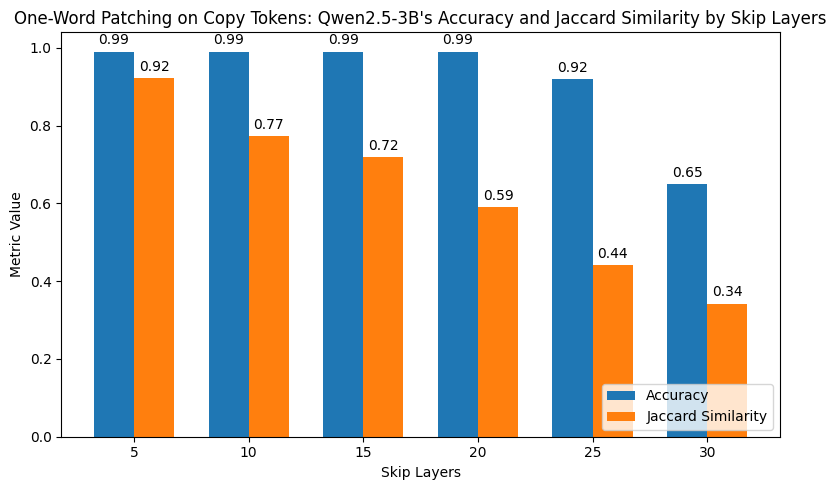

In [21]:
# Example data based on the results:
skip_layers = [5, 10, 15, 20, 25, 30]

plot_skip_layer_metrics(skip_layers, accuracy3, jaccard_similarity, model_name="Qwen2.5-3B", schema="One-Word Patching on Copy Tokens")


# Patching with different context

In [16]:
import torch

def find_dif_pos(tensor: torch.Tensor, pos: int) -> int:
    """
    Given a tensor of shape (1, n) and an index pos, returns the index
    of the last occurrence (before the final element) of the tensor's final value,
    ensuring that the found index is different from pos.
    
    Example:
      tensor = [[31, 11, 22, 551, 11, 223, 42, 11]]
      pos = 1
      The final value is 11. The occurrences of 11 (excluding the last element) 
      are at positions 1 and 4. Since pos=1, we choose 4.
      
      Returns: 4
    """
    # Convert tensor to a 1D list (we assume tensor is of shape (1, n))
    row = tensor[0]
    final_val = row[-1].item()
    
    # Scan from the second-to-last element backwards
    for i in range(len(row) - 2, -1, -1):
        if row[i].item() == final_val and i != pos:
            return i
    return None  # or raise an error if not found

# Test example:
tensor = torch.tensor([[31, 11, 22, 551, 11, 223, 42, 11]])
pos = 1
output = find_dif_pos(tensor, pos)
print("Output:", output)  # Expected output: 4


Output: 4


In [18]:
import time
import torch
from tqdm import tqdm
from collections import defaultdict

def mini_acc(dict_pred_info):
    acc_lst = []
    for step in dict_pred_info.keys():
        copy = dict_pred_info[step]['copy']
        original = dict_pred_info[step]['original']

        acc_score = 1 if copy[0] == original[0] else 0
        acc_lst.append(acc_score)
    return sum(acc_lst) / len(acc_lst)

def has_required_spaces(seq: str, seqlen = 6) -> bool:
    """
    Returns True if the sequence has an occurrence of 'is' or 'are'
    that is preceded (anywhere earlier in the sequence) by at least 6 tokens that are exactly 'space'.
    
    Examples:
      'There space space space space space oh space is a cat.' -> True
      'There space are many cats.' -> False
      'There is a cat.' -> False
      'There space space space space space space is a cat.' -> True
      'There spaces are many cats.' -> False
    """
    tokens = seq.split()
    # check if sentence only has 1 is or are
    if tokens.count("is") + tokens.count("are") != 1:
        return False
    for i, token in enumerate(tokens):
        if token in {"is", "are"}:
            # Count how many tokens before this occurrence are exactly "space"
            if len(tokens[:i]) >= seqlen:
                return True
    return False

def text_preprocess(text):
    """Given a text, replace ' is ' by ' are ', and vice versa. Return the corrupted text, and the text until the first is/are."""
    text = text.strip()
    if ' is ' in text:
        corrupted_text = text.replace(' is ', ' are ', 1)
    elif ' are ' in text:
        corrupted_text = text.replace(' are ', ' is ', 1)
    
    # find position of first is/are and return text before that
    first_is = text.find(' is ')
    first_are = text.find(' are ')
    if first_is == -1 and first_are == -1:
        return None
    elif first_is == -1:
        return corrupted_text, text[:first_are], 'are'
    elif first_are == -1:
        return corrupted_text, text[:first_is], 'is'
    
    return corrupted_text, text[:min(first_is, first_are)]

def ngram(n, model, skip_up_to, max_steps, extra_steps, k, edited_phrases):

    print("n-gram: ", n)
    print("Skip layers: ", skip_up_to)

    info_lst = []
    failed_lst = []

    total_failed_by_prepocess = 0
    total_failed_as_ulsolvable = 0
    total_solvable_og = 0
    total_solvable_pt = 0
    total_matches = []

    num_matched = 0
    total_steps = 0

    for edited in tqdm(edited_phrases):

        if total_solvable_og == 100:
            break

        if not has_required_spaces(edited):
            continue

        # preprocess text
        edited = text_preprocess(edited)
        if edited is None:
            total_failed_by_prepocess += 1
            continue
        corrupted_text, pre_isare, correct_tobe = edited
        prompt = f"Please fix grammar of the following text: '{corrupted_text}'. The correct text is: {pre_isare}"

        # edited_ids = tokenizer.encode(edited, return_tensors='pt')
        # steps = extra_steps + edited_ids.size(1)
        # if steps > max_steps:
        #     steps = max_steps
        # total_steps += steps
        steps = 1

        dict_pred_info = defaultdict(dict)

        for step_i in range(steps):
            prompt_tokens = model.to_tokens(prompt)

            if step_i != 0:
                prompt_tokens = model.to_tokens(prompt, prepend_bos=False)

            _t_matched, _ = detect_ngram_copy(prompt_tokens, n=n, skip_up_to=skip_up_to)
            t_matched = find_dif_pos(prompt_tokens, _t_matched)
            
            # detect copy scenario
            if t_matched is not None:

                # run on the prompt once with cache to store activations to patch in later
                og_logits, og_cache = model.run_with_cache(prompt_tokens)
                # get the top k tokens
                og_topk_indices = get_top_k(og_logits, k)
                # get the highest prob token
                og_next_token = torch.tensor([og_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                # check if model can solve the task
                decoded_og_next_token = model.to_string(og_next_token)[0]
                if 'are' in decoded_og_next_token and correct_tobe == 'are':
                    total_solvable_og += 1
                elif 'is' in decoded_og_next_token and correct_tobe == 'is':
                    total_solvable_og += 1
                else:
                    continue
            
                # num_matched += 1

                def residual_stream_patching_hook(
                    resid_pre: Float[torch.Tensor, "batch pos d_model"],
                    hook: HookPoint,
                    position: int
                ) -> Float[torch.Tensor, "batch pos d_model"]:
                    # Each HookPoint has a name attribute giving the name of the hook.
                    clean_resid_pre = og_cache[hook.name]
                    resid_pre[:, -1, :] = clean_resid_pre[:, position, :]
                    return resid_pre
                
                # Use functools.partial to create a temporary hook function with the position fixed
                temp_hook_fn = partial(residual_stream_patching_hook, position=t_matched)
                # Run the model with the patching hook
                patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                    (utils.get_act_name("resid_pre", skip_up_to), temp_hook_fn)
                ])

                # def v_patching_hook(
                #     resid_pre: Float[torch.Tensor, "batch pos head_index d_head"],
                #     hook: HookPoint,
                #     position: int
                # ) -> Float[torch.Tensor, "batch pos head_index d_head"]:
                #     # Each HookPoint has a name attribute giving the name of the hook.
                #     clean_resid_pre = og_cache[hook.name]
                #     resid_pre[:, -1, :, :] = clean_resid_pre[:, position, :, :]
                #     return resid_pre
                
                # for layer in range(skip_up_to):
                #     # Use functools.partial to create a temporary hook function with the position fixed
                #     temp_hook_fn = partial(v_patching_hook, position=t_matched)
                #     # Run the model with the patching hook
                #     patched_logits = model.run_with_hooks(prompt_tokens, fwd_hooks=[
                #         (utils.get_act_name("v", layer), temp_hook_fn)
                #     ])
                
                pt_topk_indices = get_top_k(patched_logits, k)
                # get the highest prob token
                pt_next_token = torch.tensor([pt_topk_indices[0]]).unsqueeze(0).to(og_logits.device)

                if torch.equal(og_next_token, pt_next_token):
                    total_matches.append(1)
                else:
                    total_matches.append(0)

                # # append the token to the sequence
                # pt_prompt_tokens = torch.cat([prompt_tokens, pt_next_token], dim=1)
                # # deocde the token
                # pt_prompt = model.to_string(pt_prompt_tokens)[0]      
                # print('PT:\n')
                # print(pt_prompt)

                dict_pred_info[step_i]['original'] = og_topk_indices
                dict_pred_info[step_i]['copy'] = get_top_k(patched_logits, k)

        info_lst.append(dict_pred_info)
        
    jcc, acc = get_acc(info_lst)
    print("Avg jaccard similarity: ", jcc)
    print("Avg accuracy 2: ", acc)
    print("Avg accuracy 3: ", sum(total_matches) / len(total_matches))
    print('Num samples: ', total_solvable_og)

In [21]:
seed = 5
extra_steps = 5
max_steps = 1024
k=100
seed_everything(seed)

ns = [5]
skip_up_to = [5, 10, 15, 20, 25, 30]
info_lst = {}
for n in ns:
    info_lst[n] = {}
    for skip in skip_up_to:
        info_lst[n][skip] = {}
        outputs = ngram(n, model, skip, max_steps, extra_steps, k, edited_sents)
        print("-----------------------------------")

n-gram:  5
Skip layers:  5


 94%|█████████▎| 4683/5000 [00:17<00:01, 261.01it/s]


Avg jaccard similarity:  0.8551444379311276
Avg accuracy 2:  0.94
Avg accuracy 3:  0.94
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  10


 94%|█████████▎| 4683/5000 [00:18<00:01, 258.03it/s]


Avg jaccard similarity:  0.7753769623425248
Avg accuracy 2:  0.82
Avg accuracy 3:  0.82
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  15


 94%|█████████▎| 4683/5000 [00:18<00:01, 256.28it/s]


Avg jaccard similarity:  0.6921447915497371
Avg accuracy 2:  0.7
Avg accuracy 3:  0.7
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  20


 94%|█████████▎| 4683/5000 [00:18<00:01, 256.16it/s]


Avg jaccard similarity:  0.49924186942621895
Avg accuracy 2:  0.48
Avg accuracy 3:  0.48
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  25


 94%|█████████▎| 4683/5000 [00:18<00:01, 255.55it/s]


Avg jaccard similarity:  0.32867903281746097
Avg accuracy 2:  0.16
Avg accuracy 3:  0.16
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  30


 94%|█████████▎| 4683/5000 [00:18<00:01, 253.60it/s]

Avg jaccard similarity:  0.21817942240780497
Avg accuracy 2:  0.04
Avg accuracy 3:  0.04
Num samples:  100
-----------------------------------


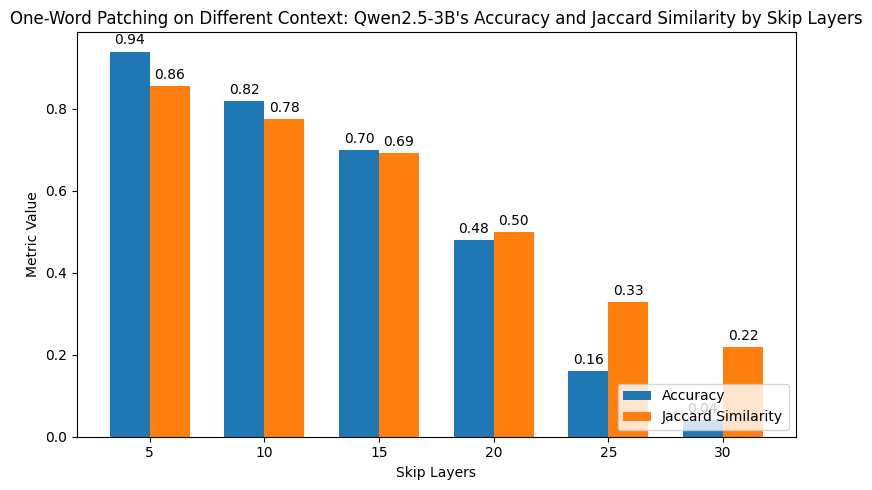

In [22]:
text = '''
n-gram:  5
Skip layers:  5
 94%|█████████▎| 4683/5000 [00:17<00:01, 261.01it/s]
Avg jaccard similarity:  0.8551444379311276
Avg accuracy 2:  0.94
Avg accuracy 3:  0.94
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  10
 94%|█████████▎| 4683/5000 [00:18<00:01, 258.03it/s]
Avg jaccard similarity:  0.7753769623425248
Avg accuracy 2:  0.82
Avg accuracy 3:  0.82
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  15
 94%|█████████▎| 4683/5000 [00:18<00:01, 256.28it/s]
Avg jaccard similarity:  0.6921447915497371
Avg accuracy 2:  0.7
Avg accuracy 3:  0.7
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  20
 94%|█████████▎| 4683/5000 [00:18<00:01, 256.16it/s]
Avg jaccard similarity:  0.49924186942621895
Avg accuracy 2:  0.48
Avg accuracy 3:  0.48
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  25
 94%|█████████▎| 4683/5000 [00:18<00:01, 255.55it/s]
Avg jaccard similarity:  0.32867903281746097
Avg accuracy 2:  0.16
Avg accuracy 3:  0.16
Num samples:  100
-----------------------------------
n-gram:  5
Skip layers:  30
 94%|█████████▎| 4683/5000 [00:18<00:01, 253.60it/s]Avg jaccard similarity:  0.21817942240780497
Avg accuracy 2:  0.04
Avg accuracy 3:  0.04
Num samples:  100
-----------------------------------
'''
accuracy3, jaccard_similarity = extract_metrics(text)

# Example data based on the results:
skip_layers = [5, 10, 15, 20, 25, 30]

plot_skip_layer_metrics(skip_layers, accuracy3, jaccard_similarity, model_name="Qwen2.5-3B", schema="One-Word Patching on Different Context")
